In [2]:
import matplotlib.pyplot as plt
import os
import numpy as np
import torch
import torch.nn as nn
import torch.fft as fft
import torch.nn.functional as F
import torch.distributions as dist
from   scipy.stats import lognorm
import skimage.morphology
from skimage.morphology import ball
import tifffile

In [2]:
dirpath = "_beads_roi_extracted"
beadslist = [os.path.join(dirpath, f) for f in sorted(os.listdir(dirpath))]
beadslist


['_beads_roi_extracted/beads_001_roi000.pt',
 '_beads_roi_extracted/beads_001_roi001.pt',
 '_beads_roi_extracted/beads_001_roi002.pt',
 '_beads_roi_extracted/beads_001_roi003.pt',
 '_beads_roi_extracted/beads_001_roi004.pt',
 '_beads_roi_extracted/beads_001_roi005.pt',
 '_beads_roi_extracted/beads_001_roi006.pt',
 '_beads_roi_extracted/beads_001_roi007.pt',
 '_beads_roi_extracted/beads_001_roi008.pt',
 '_beads_roi_extracted/beads_001_roi009.pt',
 '_beads_roi_extracted/beads_001_roi010.pt',
 '_beads_roi_extracted/beads_002_roi000.pt',
 '_beads_roi_extracted/beads_002_roi001.pt',
 '_beads_roi_extracted/beads_002_roi002.pt']

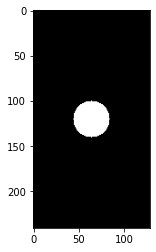

In [4]:
def make_ball(r = 10, datasize = [240, 128, 128]):
    data     = np.zeros(datasize)
    datasize = np.array(datasize)
    s        = 'ball' # 'octahedron', 'cube'
    form     = getattr(skimage.morphology, s)(r).astype(np.float32)
    z, x, y  = datasize // 2 - r
    z_max    = min(z + form.shape[0], datasize[0])
    x_max    = min(x + form.shape[1], datasize[1])
    y_max    = min(y + form.shape[2], datasize[2])
    data[z : z + form.shape[0],
         x : x + form.shape[1],
         y : y + form.shape[2],]\
    += \
    form[0 : z_max - z        ,
         0 : x_max - x        ,
         0 : y_max - y        ,]
    data = data > 0
    data = torch.from_numpy(data) * 1.
    data = data.unsqueeze(0)
    return data

obj = make_ball(r=20, datasize=[241, 129, 129])
obj = obj / torch.sum(obj)
nd_data = obj.detach().numpy().copy()
obj = obj.to("cuda").to(torch.float64)
plt.imshow(nd_data[0, :, 64, :], cmap='gray', vmin=0)
plt.show()

In [5]:
tifffile.imwrite("beadsdata/beaddata0.tif", nd_data[0])

In [4]:
class Deconvolution():
    def __init__(self):
        super().__init__()
        self.device  = 'cuda' if torch.cuda.is_available() else 'cpu'

    def padding_kernel(self, H, y,):
        H_pad = [(y.size(3) - H.size(3)) // 2 + 1, (y.size(3) - H.size(3)) // 2,
                 (y.size(2) - H.size(2)) // 2 + 1, (y.size(2) - H.size(2)) // 2,
                 (y.size(1) - H.size(1)) // 2 + 1, (y.size(1) - H.size(1)) // 2]
        padded_H = F.pad(H, H_pad)
        return padded_H

    def c_max(self, h, eps):
        h[h.abs() <= eps] = eps
        return h

    def laplacian_filtering(self, x):
        laplacian_filter = torch.DoubleTensor(
            [[[0. , 0. , 0. ],
              [0. , 1. , 0. ],
              [0. , 0. , 0. ],],
             
             [[0. , 1. , 0. ],
              [1. ,-6. , 1. ],
              [0. , 1. , 0. ],],
             
             [[0. , 0. , 0. ],
              [0. , 1. , 0. ],
              [0. , 0. , 0. ],]]).view(1, 1, 3, 3, 3).to(self.device)

        x = F.conv3d(input  = x               ,
                     weight = laplacian_filter,
                     stride = 1               ,
                     padding= 1               ,)
        return x

    def laplacian_filtering_(self, x):
        laplacian_filter = torch.DoubleTensor(
            [[[0. , 0. , 0. ],
              [0. , 1. , 0. ],
              [0. , 0. , 0. ],],
             
             [[0. , 1. , 0. ],
              [1. ,-6. , 1. ],
              [0. , 1. , 0. ],],
             
             [[0. , 0. , 0. ],
              [0. , 1. , 0. ],
              [0. , 0. , 0. ],]]).view(1, 1, 3, 3, 3).to(self.device)

        x = F.conv3d(input  = x               ,
                     weight = laplacian_filter,
                     stride = 1               ,
                     padding= 1               ,)
        return x

    def iteration(self, H, y):
        x_k  = torch.clip(torch.zeros_like(y) + 0.5, min=0, max=1) # 初期値の設定はskimage.restorationを参考にした
        x_k_ = fft.fftn(x_k).flatten()
        H    = self.padding_kernel(H, y)
        H_   = fft.fftn(H).flatten()
        y_   = fft.fftn(y).flatten()
        with torch.no_grad():
            for k in range(self.M_iter):            
                x_k_ = self.update(x_k_, H_, y_)        
        x_k = x_k_.view(x_k.shape)
        x_k = fft.fftshift(fft.ifftn((x_k)).real)
        return x_k

    def direct_minimization(self, H, y):
        x = self.minimizer(H, y)
        return x


class NaiveInverseFiltering(Deconvolution):
    def __init__(self, eps):
        super().__init__()
        self.eps = torch.tensor(eps)

    def loss(self, y, H, x):
        return torch.sum((y - H * x)**2)

    def minimizer(self, y, H):
        y_hat = torch.fft.fftn(y)
        H = self.padding_kernel(H, y)
        h_hat = torch.fft.fftn(H)
        x_tilde_hat = y_hat / self.c_max(h_hat, self.eps)
        x_tilde =fft.fftshift(fft.ifftn((x_tilde_hat)).real)
        return x_tilde


class RegularizedInverseFiltering(Deconvolution):
    def __init__(self, lambda_):
        super().__init__()
        self.lambda_ = torch.tensor(lambda_)

    def minimizer(self, y, H):
        L    = self.laplacian_filtering(y)
        L_   = torch.fft.fftn(L).flatten()
        y_   = torch.fft.fftn(y).flatten()
        H    = self.padding_kernel(H, y)
        H_   = torch.fft.fftn(H).flatten()
        x_tilde_hat_ \
        = (H_.conj() / (H_.abs() ** 2 + self.lambda_ * L_.abs() ** 2)) * y_ 
        x_tilde_hat  = x_tilde_hat_.view(y.shape)
        x_tilde = fft.fftshift(fft.ifftn((x_tilde_hat)).real)
        return x_tilde
    

class TikhonovRegularization(Deconvolution):
    def __init__(self, lambda_):
        super().__init__()
        self.lambda_ = torch.tensor(lambda_)

    def loss(self, y, H, x):
        return torch.sum((y - H * x)**2 + self.lambda_ * x ** 2) 

    def minimizer(self, y, H):
        y_   = torch.fft.fftn(y).flatten()
        H    = self.padding_kernel(H, y)
        H_   = torch.fft.fftn(H).flatten()
        H_T_ = H_.conj()
        x_tilde_hat_ = (H_.conj() / (H_.abs() ** 2 + self.lambda_)) * y_ #対角行列Aの逆行列はAの対角成分の逆数に等しい対角行列
        x_tilde_hat  = x_tilde_hat_.view(y.shape)
        x_tilde = fft.fftshift(fft.ifftn((x_tilde_hat)).real)
        return x_tilde
    

class Landweber(Deconvolution):
    def __init__(self, gamma, M_iter):
        super().__init__()
        self.gamma  = gamma
        self.M_iter = M_iter

    def update(self, x, H, y,):
        x = self.c_max((x + self.gamma * H.conj() * (y - H * x)), 0)
        return x
    

class TikhonovMiller(Deconvolution):
    def __init__(self, lambda_, gamma, M_iter):
        super().__init__()
        self.lambda_ = lambda_
        self.gamma   = gamma
        self.M_iter  = M_iter
        
    def tm_iteration(self, H, y):
        x_k  = torch.clip(torch.zeros_like(y) + 0.5, min=0, max=1) # 初期値の設定はskimage.restorationを参考にした
        x_k_ = fft.fftn(x_k).flatten()
        H    = self.padding_kernel(H, y)
        H_   = fft.fftn(H).flatten()
        y_   = fft.fftn(y).flatten()
        L    = self.laplacian_filtering(y)
        L_   = torch.fft.fftn(L).flatten()
        with torch.no_grad():
            for k in range(self.M_iter):            
                x_k_ = self.update(x_k_, H_, L_, y_)        
        x_k = x_k_.view(x_k.shape)
        x_k = fft.fftshift(fft.ifftn((x_k)).real)
        return x_k

    def update(self, x, H, L, y,):
        hh_lll = (H.abs() ** 2 + self.lambda_ * L.abs() ** 2)
        x = x + self.gamma * (H.conj() * y - hh_lll * x)
        x = self.c_max(x.real, 0) # 正の実数に射影（iterative constraint）
        return x
    

class RichardsonLucy(Deconvolution):
    def __init__(self, M_iter):
        super().__init__()
        self.M_iter  = M_iter

    def rl_iteration(self, H, y):
        y   = y.unsqueeze(0).to(self.device)
        H   = H.unsqueeze(0).to(self.device)
        x_k = torch.clip(torch.zeros_like(y, device=self.device) + 0.5, min=0, max=1)# 初期値の設定はskimage.restorationを参考にした
        H_T = torch.flip(H, (-3, -2, -1))
        eps = 1e-12
        with torch.no_grad():
            for k in range(self.M_iter):
                H_x_k = F.conv3d(input   = x_k               ,
                                 weight  = H                 ,
                                 padding = (H.shape[-3] // 2,
                                            H.shape[-2] // 2,
                                            H.shape[-1] // 2,),) + eps
                y_Hx  = y / H_x_k
                x_k  *= F.conv3d(input   = y_Hx              ,
                                 weight  = H_T               ,
                                 padding = (H_T.shape[-3] // 2,
                                            H_T.shape[-2] // 2,
                                            H_T.shape[-1] // 2,),) + eps
                x_k = torch.clip(x_k, 0, 1)

        return x_k.squeeze(0)
    

class RichardsonLucyWithTV(Deconvolution):
    """
    Reference: https://github.com/ctom2/torch-deconvolution/blob/main/richardsonlucy_tv.py
    """
    def __init__(self, lambda_, M_iter):
        super().__init__()
        self.lambda_ = lambda_
        self.M_iter  = M_iter

    def rltv_iteration(self, H, y):
        y   = y.unsqueeze(0).to(self.device)
        H   = H.unsqueeze(0).to(self.device)
        x_k = torch.clip(torch.zeros_like(y, device=self.device) + 0.5,
                         min=0, max=1) # 初期値の設定はskimage.restorationを参考にした
        H_T = torch.flip(H, (-3, -2, -1))
        eps = 1e-12
        for k in range(self.M_iter):
            Dx   = torch.gradient(x_k[0, 0], axis=(0, 1, 2))
            norm = torch.sqrt(torch.square(Dx[0]) \
                            + torch.square(Dx[1]) \
                            + torch.square(Dx[2]) ) + eps
            Dx   = torch.stack(Dx) / norm
            g    = torch.gradient(Dx[0], axis=0)[0] \
                 + torch.gradient(Dx[1], axis=1)[0] \
                 + torch.gradient(Dx[2], axis=2)[0]
            reg  = 1 / (1 - self.lambda_ * g)

            H_x_k = F.conv3d(input   = x_k                ,
                             weight  = H                  ,
                             padding = (H.shape[-3] // 2,
                                        H.shape[-2] // 2,
                                        H.shape[-1] // 2,),) + eps
            y_Hx  = y / H_x_k
            x_k  *=(F.conv3d(input   = y_Hx                 ,
                             weight  = H_T                  ,
                             padding = (H_T.shape[-3] // 2,
                                        H_T.shape[-2] // 2,
                                        H_T.shape[-1] // 2,),) + eps) * reg
            x_k = torch.clip(x_k, 0, 1)

        return x_k.squeeze(0)

torch.Size([1, 24, 128, 128])


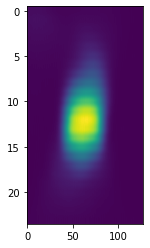

In [5]:
y_img = torch.load(beadslist[0], map_location="cuda")
#upsample = nn.Upsample(scale_factor = (10, 1, 1)   ,
#                       mode         = 'trilinear'  ,)
#y_img = upsample(y_img.unsqueeze(0)).squeeze(0)
print(y_img.shape)
y_imshow = y_img[0, :, 64, :].detach().cpu().numpy()
plt.imshow(y_imshow, aspect=10)

In [6]:
def deconv(cls_method, cls_name:str, obj=obj, beadslist=beadslist[:-1], aspect=1):
    for bead in beadslist:
        y_img = torch.load(bead, map_location="cuda")
        y_imshow = y_img[0, :, 64, :].detach().cpu().numpy()
        x_tilde = cls_method(obj,y_img)
        x_tilde_img = x_tilde[0, :, 64, :].detach().to('cpu').numpy()
        fig = plt.figure(figsize=(7, 5))
        plt.title(f'{cls_name}\n{bead[21:-3]}', y=1.08)
        plt.axis('off')
        ax1 = fig.add_subplot(121, title='$y$')
        ax2 = fig.add_subplot(122, title='$\widetilde{H}$')
        ax1.imshow(y_imshow, vmin=0, vmax=1,aspect=10, cmap='gray')
        ax2.imshow(x_tilde_img,aspect=aspect, cmap='gray')
        fig.show()

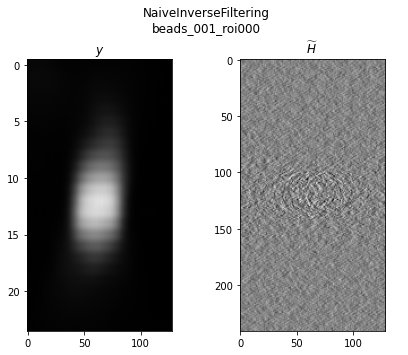

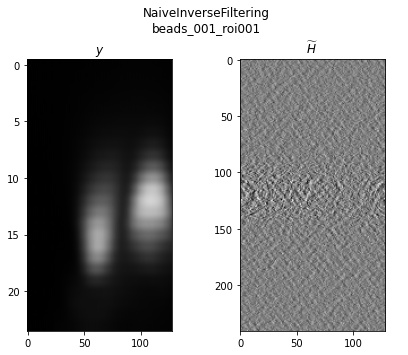

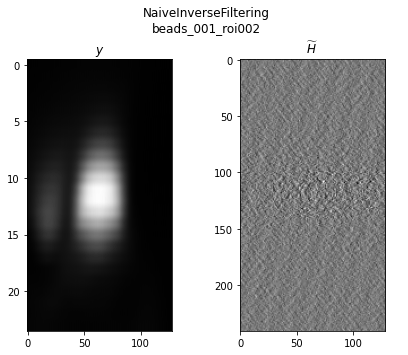

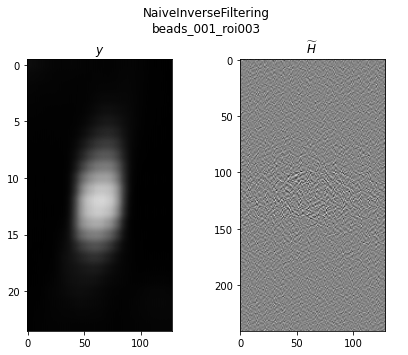

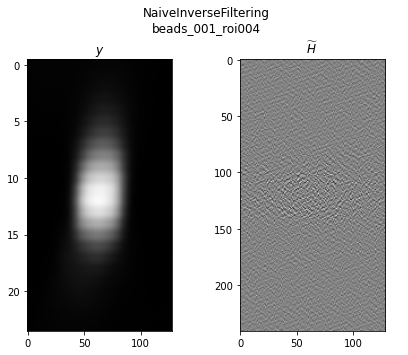

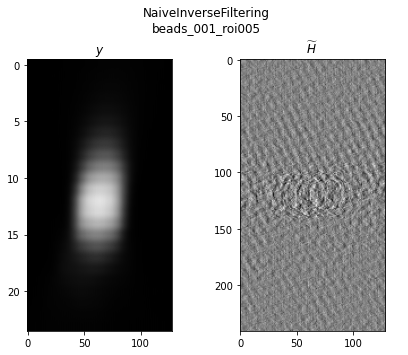

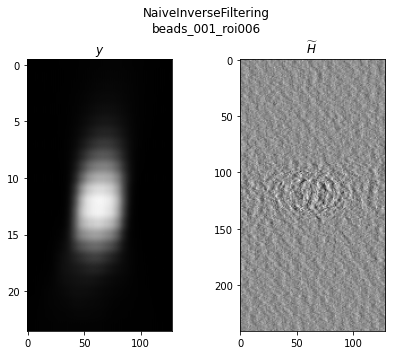

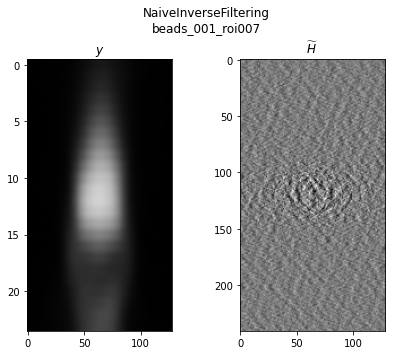

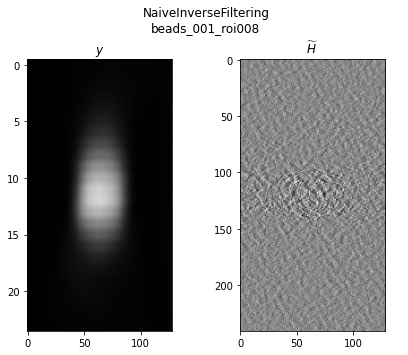

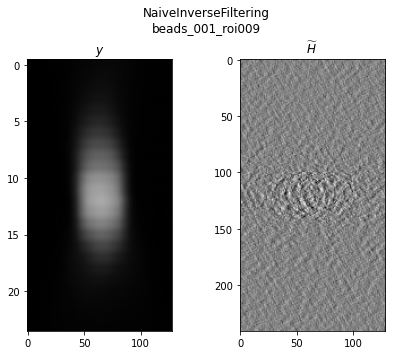

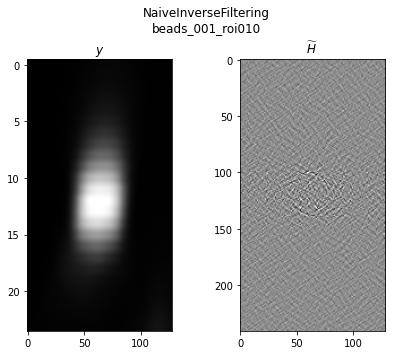

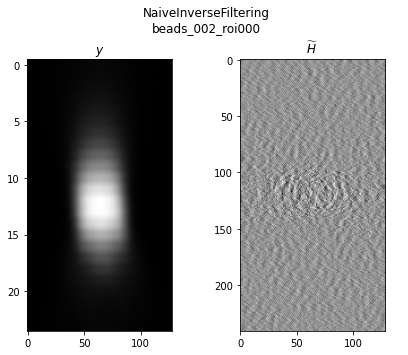

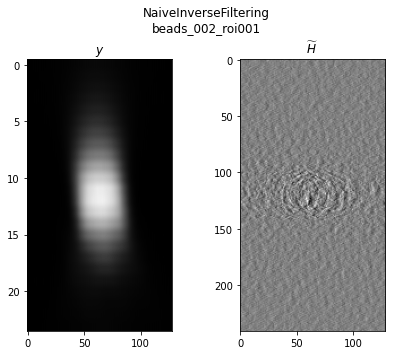

In [7]:
nif = NaiveInverseFiltering(1e-5)
deconv(nif.direct_minimization, "NaiveInverseFiltering")

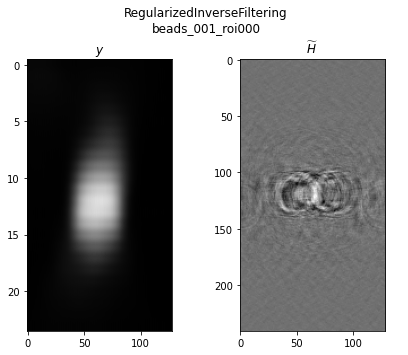

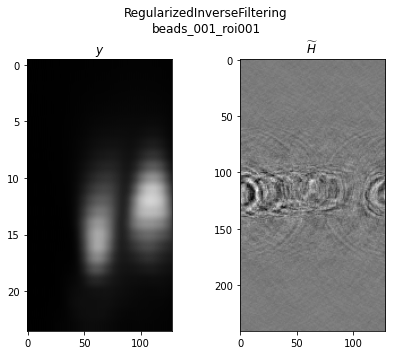

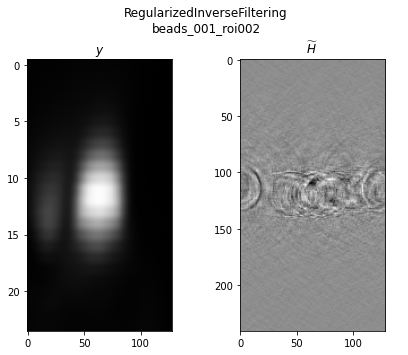

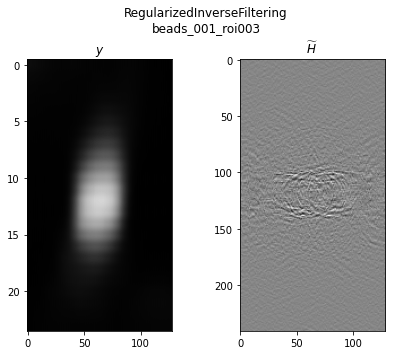

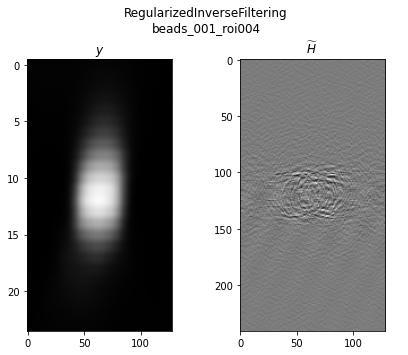

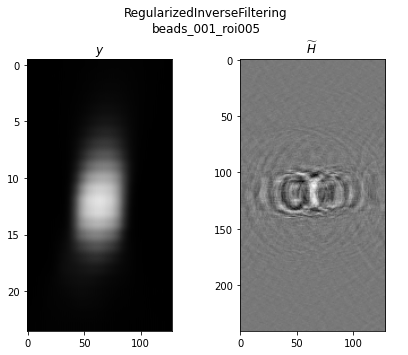

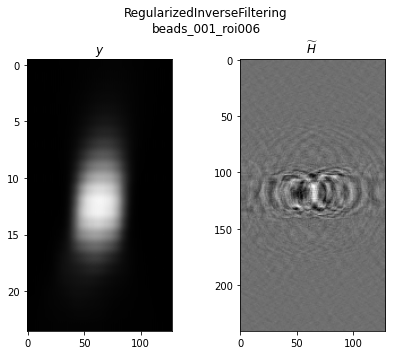

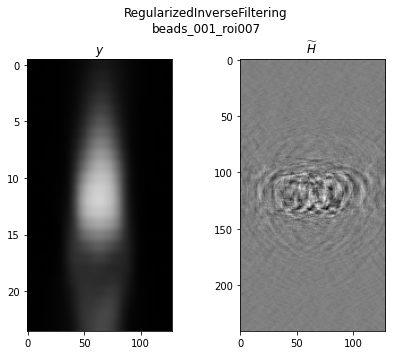

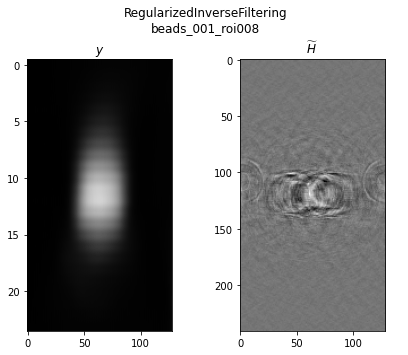

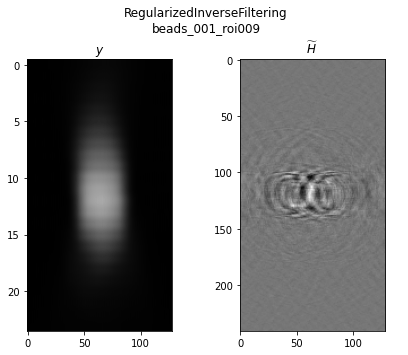

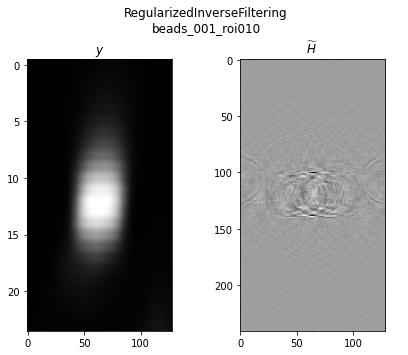

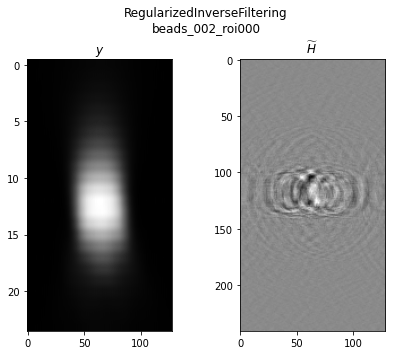

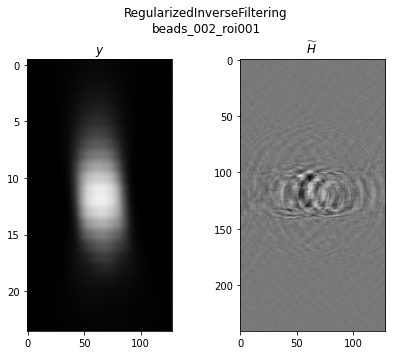

In [8]:
rif = RegularizedInverseFiltering(1e5)
deconv(rif.direct_minimization, "RegularizedInverseFiltering")

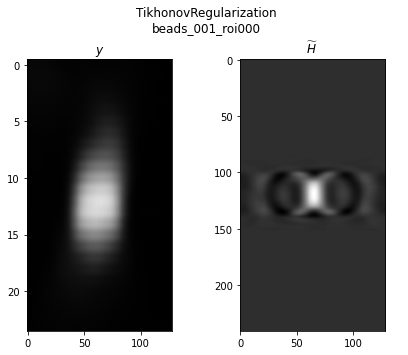

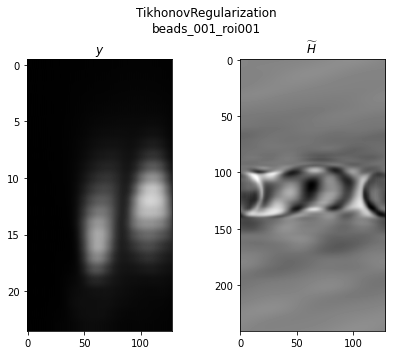

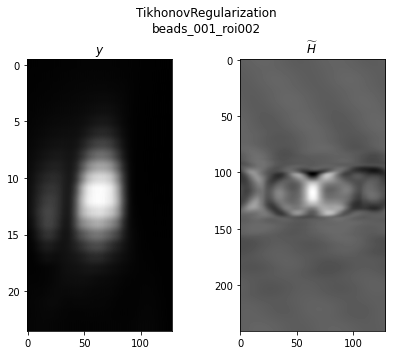

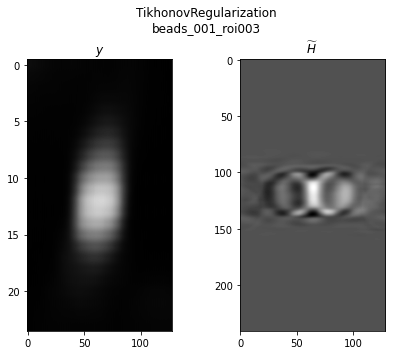

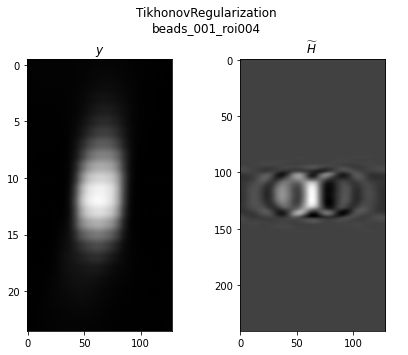

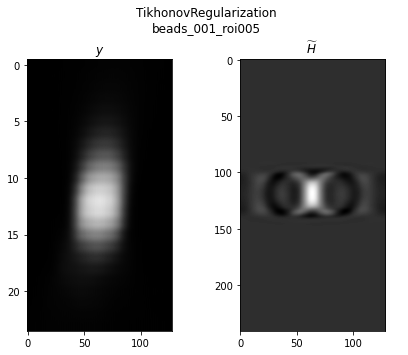

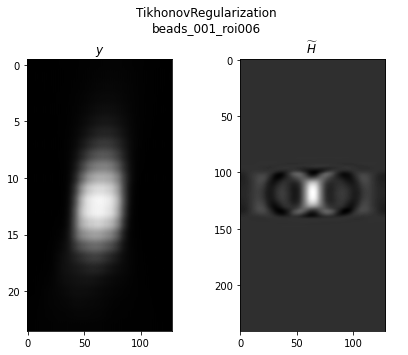

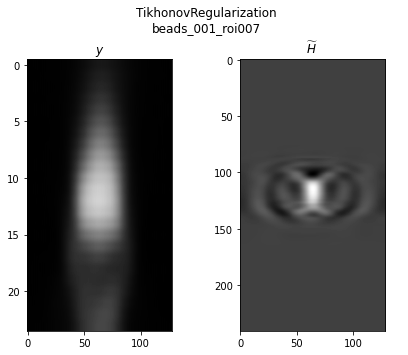

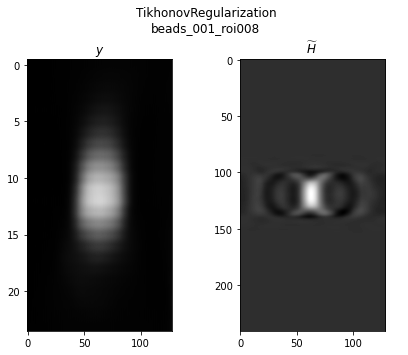

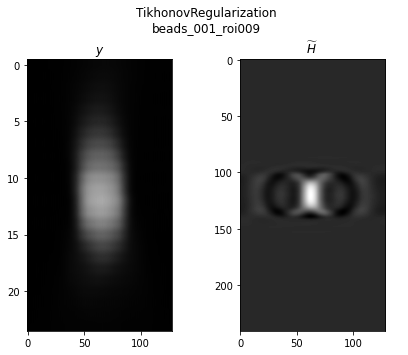

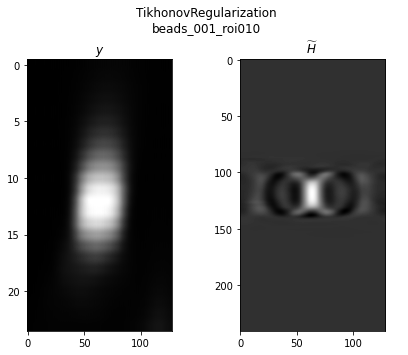

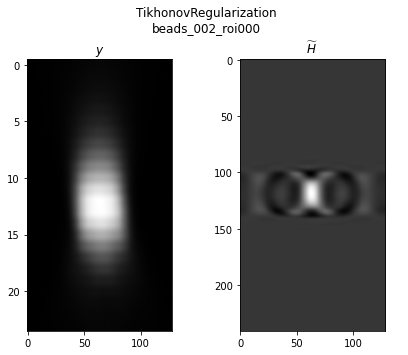

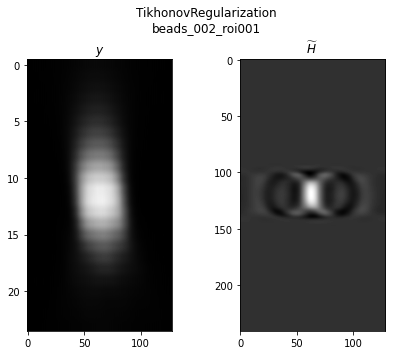

In [9]:
tif = TikhonovRegularization(1e5)
deconv(tif.direct_minimization, "TikhonovRegularization")

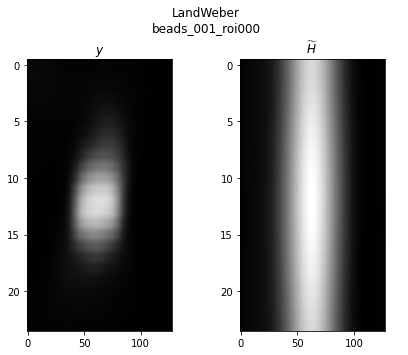

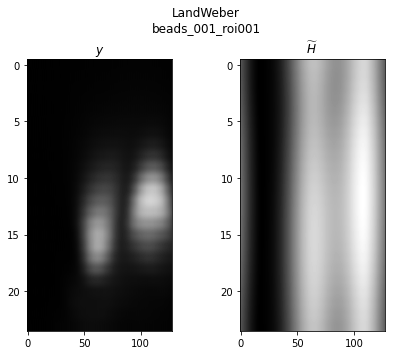

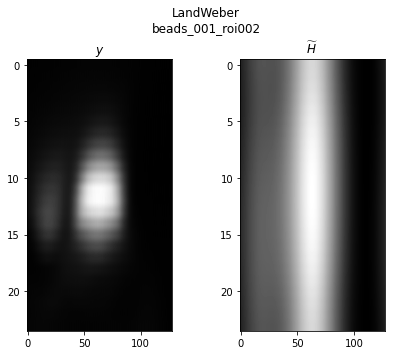

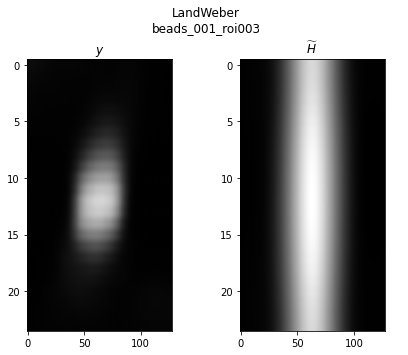

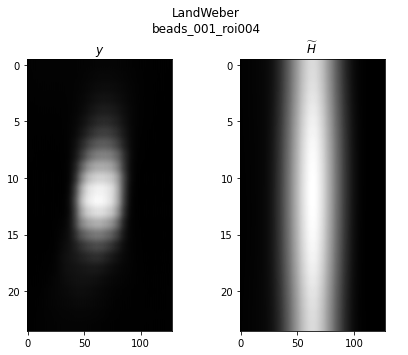

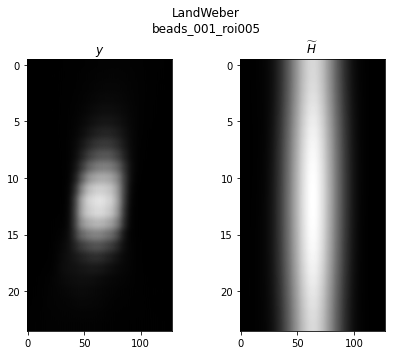

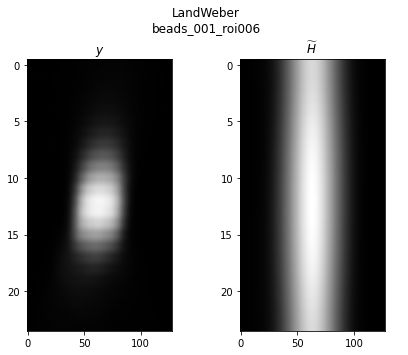

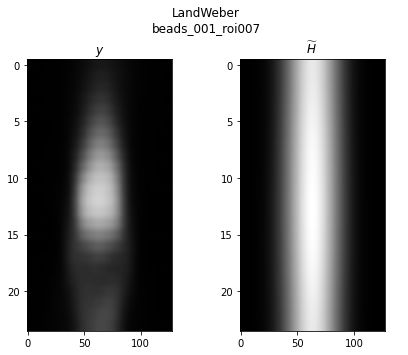

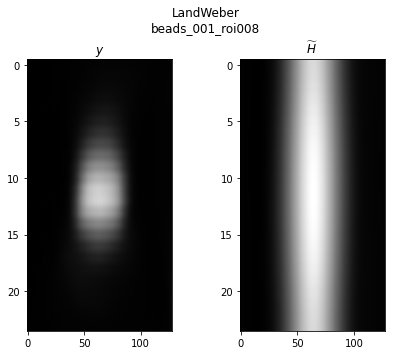

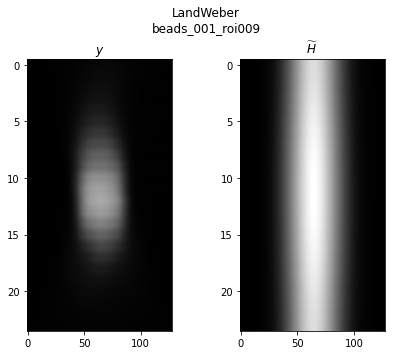

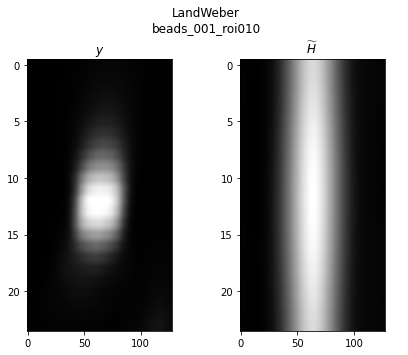

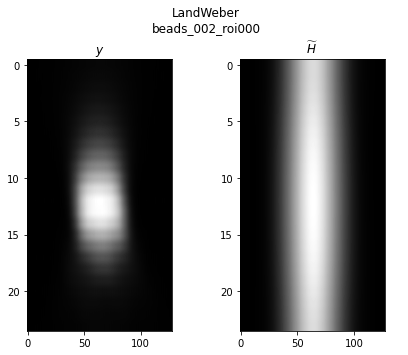

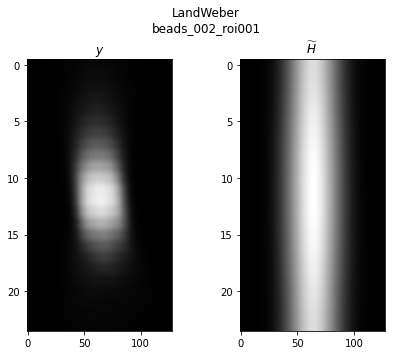

In [10]:
lw = Landweber(gamma=0.01, M_iter=5)
deconv(lw.iteration, "LandWeber", aspect=10)

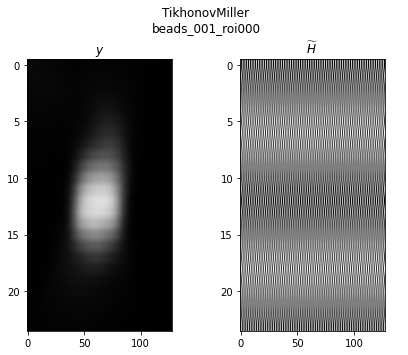

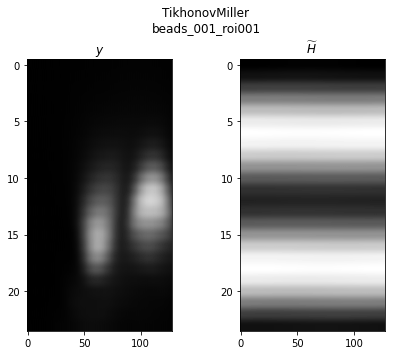

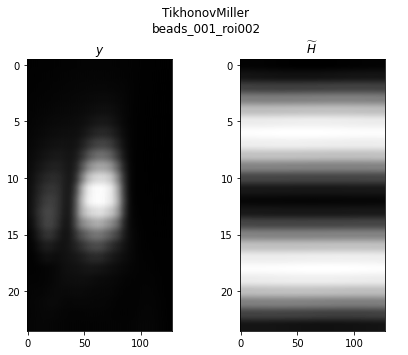

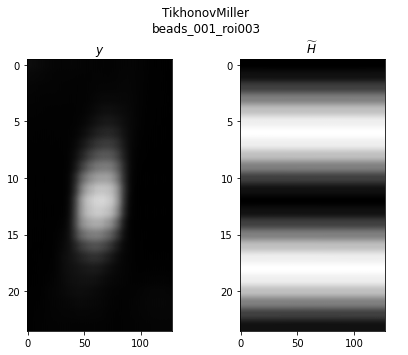

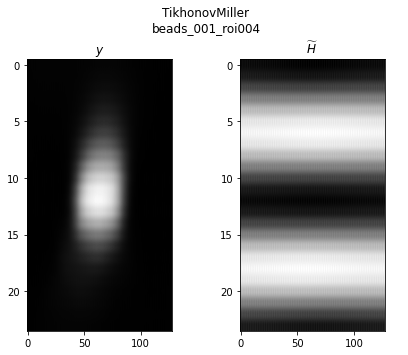

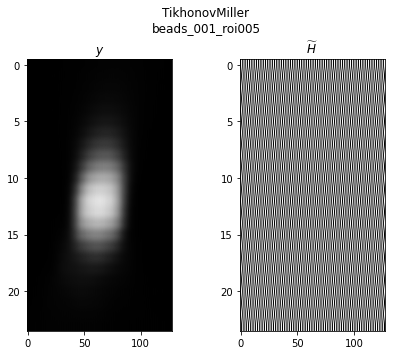

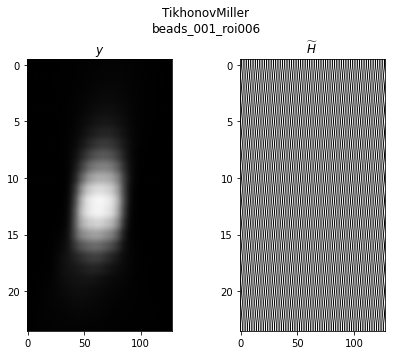

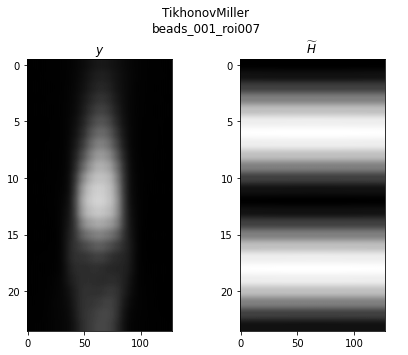

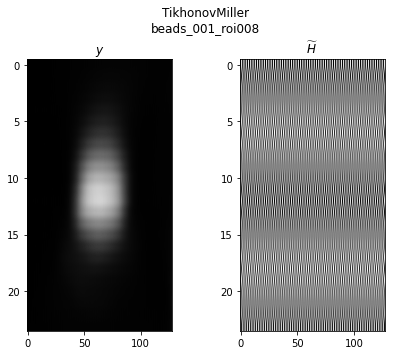

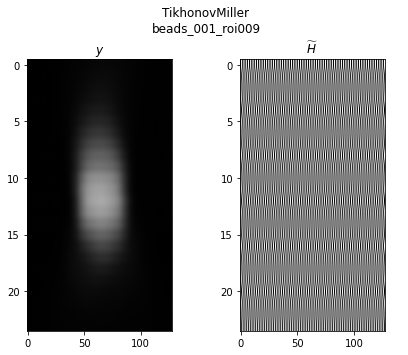

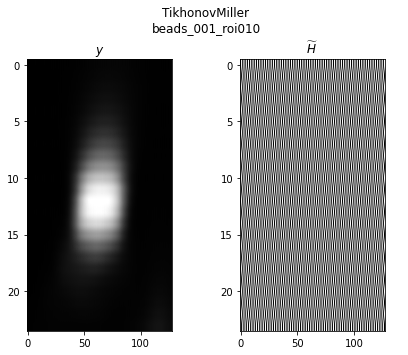

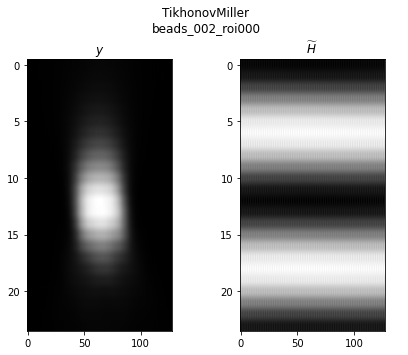

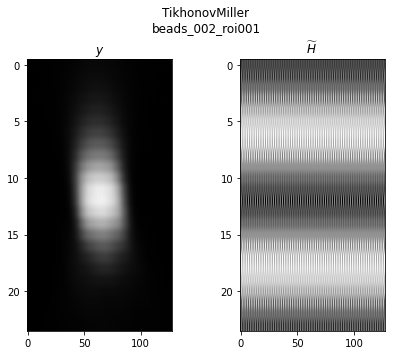

In [11]:
tm = TikhonovMiller(lambda_=1e3, gamma=0.01, M_iter=11)
deconv(tm.tm_iteration, "TikhonovMiller", aspect=10)

In [12]:
#rl = RichardsonLucy(10)
#deconv(rl.rl_iteration, "RichardsonLucy", aspect=10)

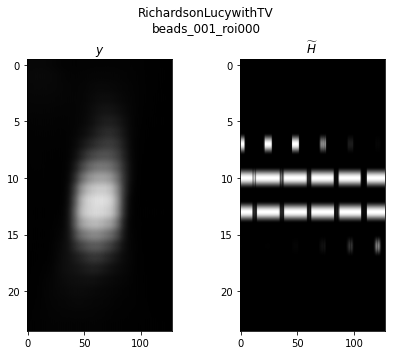

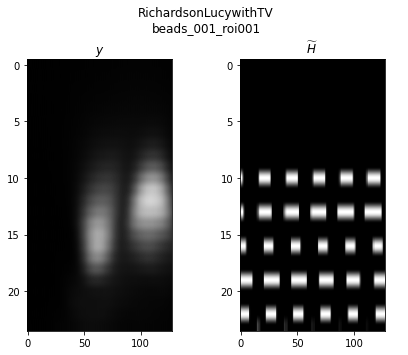

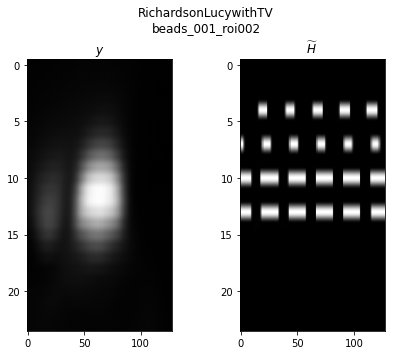

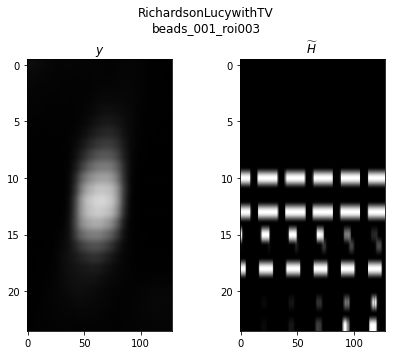

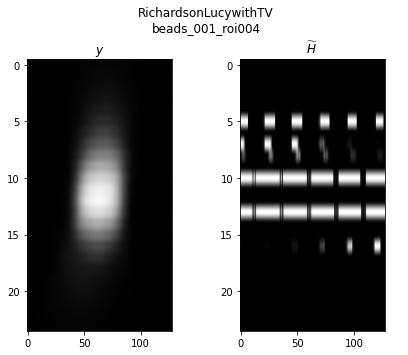

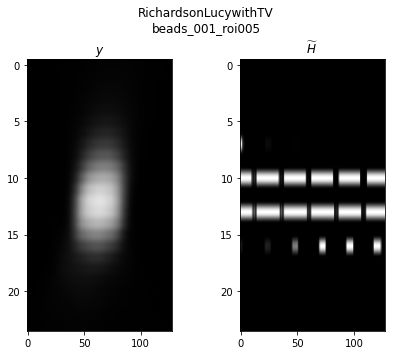

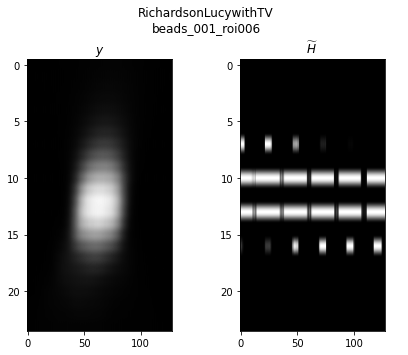

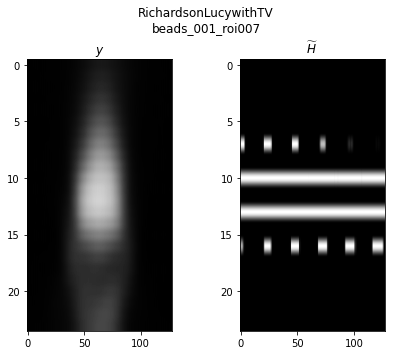

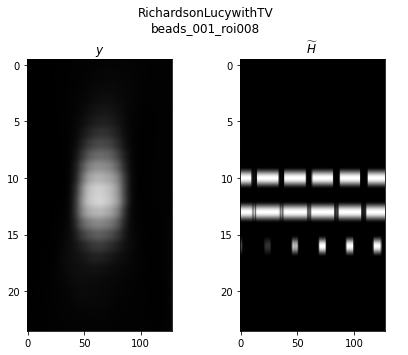

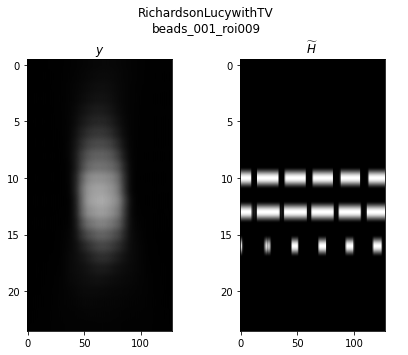

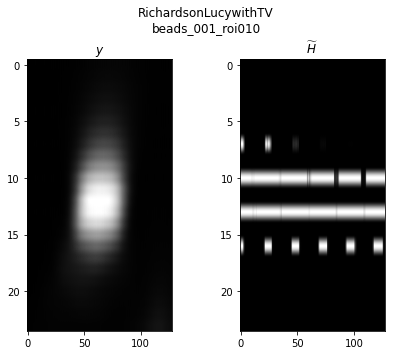

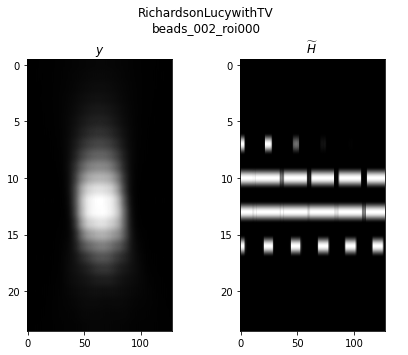

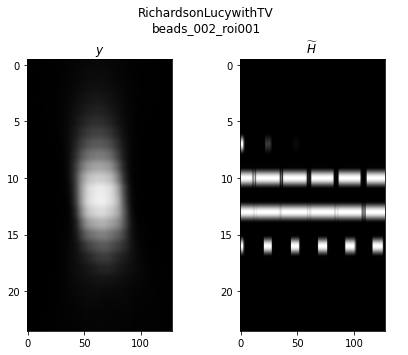

In [ ]:
#rltv = RichardsonLucyWithTV(0.1, 50)
#deconv(rltv.rltv_iteration, "RichardsonLucywithTV", aspect=10)